In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
from pyg_classifier.model import Diff_CG_Classifier
from pyg_classifier.test import diff_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that i0/m0/other is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

Epoch 0: Training loss 16.4051, Validation loss 18.2579, learning rate 0.00100
	 Validation MAE: 14.9282
Epoch 5: Training loss 8.6761, Validation loss 18.9686, learning rate 0.00100
	 Validation MAE: 15.6739
Epoch 10: Training loss 8.1339, Validation loss 18.2432, learning rate 0.00100
	 Validation MAE: 14.9821
Epoch 15: Training loss 7.8621, Validation loss 18.5209, learning rate 0.00100
	 Validation MAE: 15.2985
Epoch 20: Training loss 7.3475, Validation loss 18.4500, learning rate 0.00100
	 Validation MAE: 15.3748
Epoch 25: Training loss 6.0077, Validation loss 16.4515, learning rate 0.00099
	 Validation MAE: 14.8595
Epoch 30: Training loss 5.0348, Validation loss 16.6471, learning rate 0.00099
	 Validation MAE: 15.1676
Epoch 35: Training loss 5.0295, Validation loss 16.1468, learning rate 0.00099
	 Validation MAE: 14.7388
Epoch 40: Training loss 4.9966, Validation loss 16.1199, learning rate 0.00098
	 Validation MAE: 14.7744
Epoch 45: Training loss 4.2001, Validation loss 16.1199,

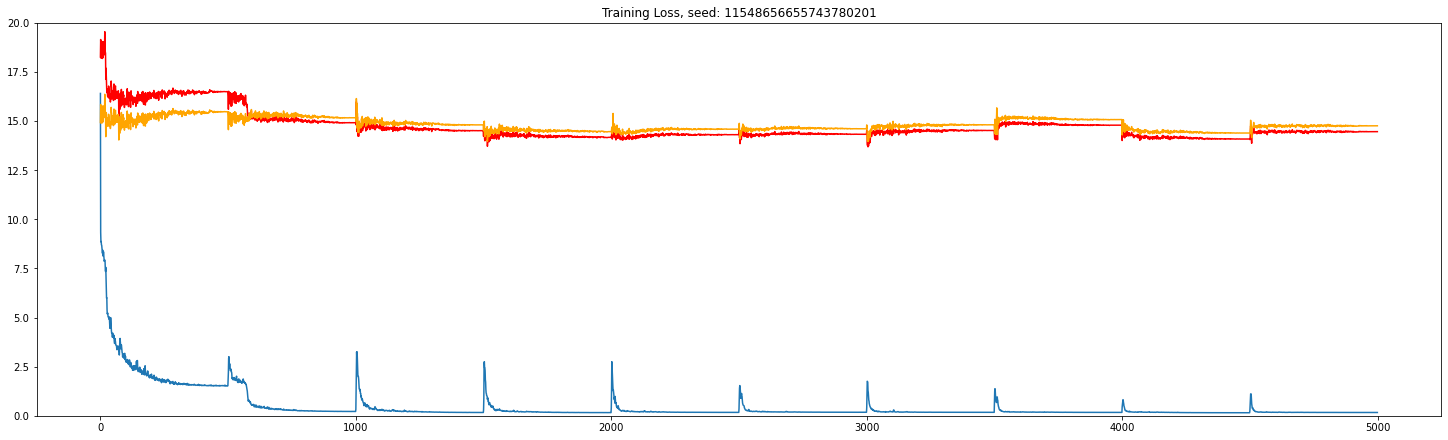

In [2]:
#Training
import time
start = time.perf_counter()

num_node_feats = training_dataset.num_node_features

seed = 11548656655743780201
th.manual_seed(seed)
th.cuda.manual_seed(seed)
#pyg.seed_everything(seed)
    
model = Diff_CG_Classifier(num_node_feats).to(device)

b_size = 64
train_dataloader = DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DenseDataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)
model.train()

epochs = 5000


#training setup
epoch_losses = []
val_losses = []
mae_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data, model.training)
        loss = F.smooth_l1_loss(pred, data.y, reduction="mean")
        final_loss = loss + l + e #trying out simple combination
        final_loss.backward()
        opt.step()
        epoch_loss += final_loss.detach().item() #loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss, l, e = training_loop(model, learning_rates, train_dataloader, scheduler, opt)
    epoch_losses.append(epoch_loss)

    #val setup
    with th.no_grad():
        model.eval()
        val_loss = 0
        mae_loss = 0
        for i, v_data in enumerate(val_dataloader):
            v_data = v_data.to(device)
            val_pred, vl, ve = model(v_data)
            v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction="mean") + vl + ve
            mae_l= F.l1_loss(val_pred, v_data.y, reduction="mean")
            mae_loss += mae_l.detach().item()
            val_loss += v_loss.detach().item()

        val_loss /= (i + 1)
        mae_loss /= (i + 1)
    
    val_losses.append(val_loss)
    mae_losses.append(mae_loss)

    th.save(model.state_dict(), "pyg_diff_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Training loss {epoch_loss:.4f}, Validation loss {val_loss:.4f}, learning rate {scheduler.get_last_lr()[0]:.5f}")
        print(f"\t Validation MAE: {mae_loss:.4f}")
        
end = time.perf_counter()

print(f"Training took {(end - start)/60/60:.2f} hours")
print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")
print(f"Seed used for training was: {th.initial_seed()}")

#plot the training run
figure, ax = plt.subplots(layout="constrained", figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, "r")
ax.plot(mae_losses, "orange")
plt.title(f"Training Loss, seed: {th.initial_seed()}")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [ ]:
#store training run data

file = "loss_data/2022-04-05_pyg_diff_b64_vec_loss_data.txt"

with open(file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates) + "\n")
    fh.write(str(mae_losses))

In [3]:
#get training run data

file = "loss_data/2022-04-01_pyg_diff_b64_vec_loss_data.txt"

file_lines = []
with open(file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.1558 in epoch 3993
Minimum Validation Loss (after 50 epochs) 13.1296 in epoch 3003
Minimum MAE (after 50 epochs) 13.3740 in epoch 3003


Validation Loss at 1800 is 14.2027
5 before select
14.2485, 14.2660, 14.2306, 14.2081, 14.2079
5 after select
14.2153, 14.1893, 14.2088, 14.2465, 14.2166
MAE at 1800 is 14.4894


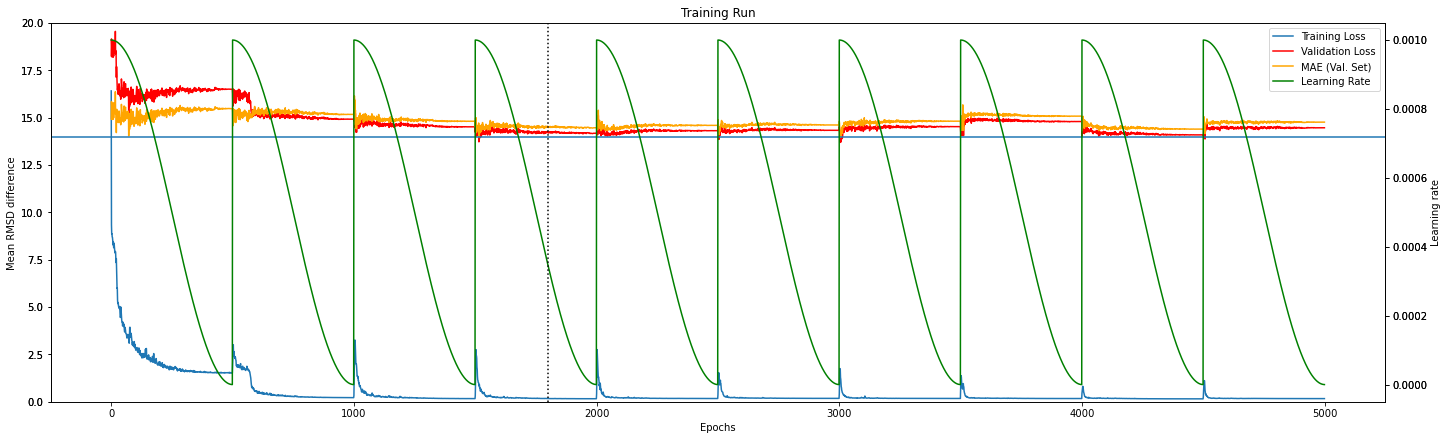

In [5]:
#plot the training run
select = 1800
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=14)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2)
plt.draw()

Test Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[37.7360]], device='cuda:0') tensor([[1.6449]], device='cuda:0') 35.59111022949219
Mean Test loss: 	 9.9915
Std. Dev. of Test loss:  7.0326
Min loss: 		 0.0000
First Quantile: 	 5.1404
Median: 		 8.8761
Third Quantile: 	 12.9608
Max Loss: 		 35.5911
LinregressResult(slope=0.5115059052594098, intercept=7.451022893222925, rvalue=0.3344034885054964, pvalue=1.1599528253027176e-08, stderr=0.08692858463587776, intercept_stderr=1.7450597335298694)


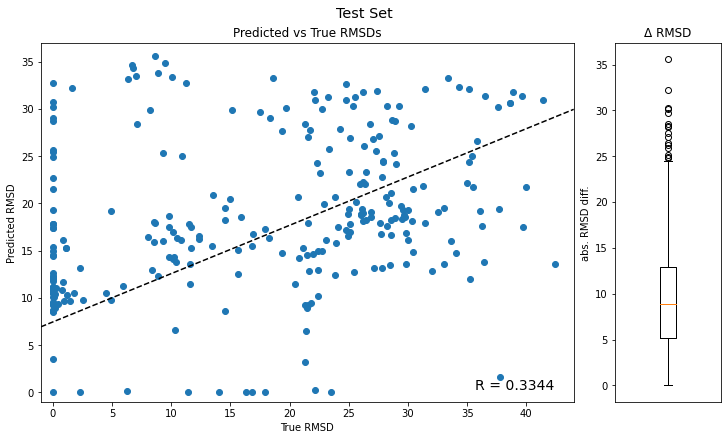

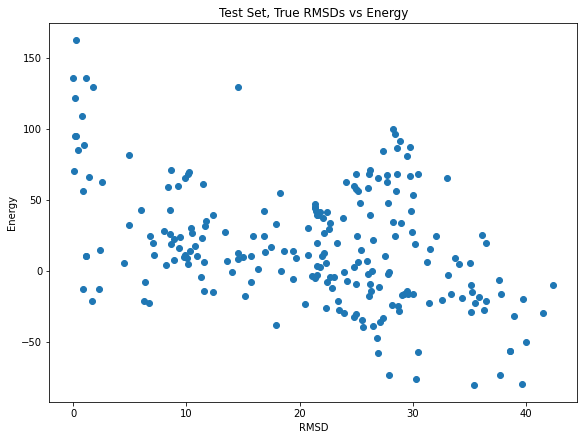

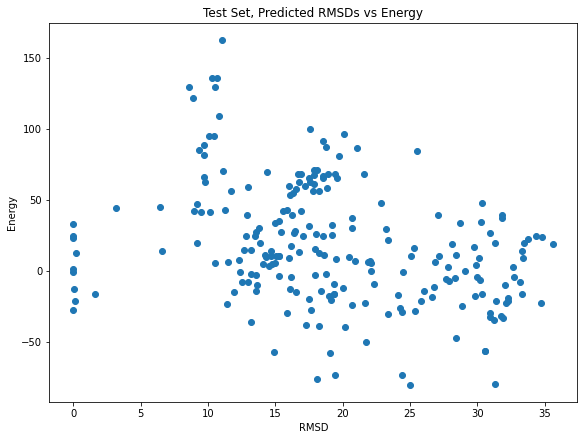

5S and tRNA Test Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[0.]], device='cuda:0') tensor([[34.1332]], device='cuda:0') 33.633243560791016
Mean Test loss: 	 4.3893
Std. Dev. of Test loss:  5.2589
Min loss: 		 0.0000
First Quantile: 	 0.9578
Median: 		 2.8933
Third Quantile: 	 5.6342
Max Loss: 		 33.6332
LinregressResult(slope=0.725732674541012, intercept=3.163550647069057, rvalue=0.6717495646782545, pvalue=4.900577655253286e-143, stderr=0.024341352228030497, intercept_stderr=0.47195372735714597)


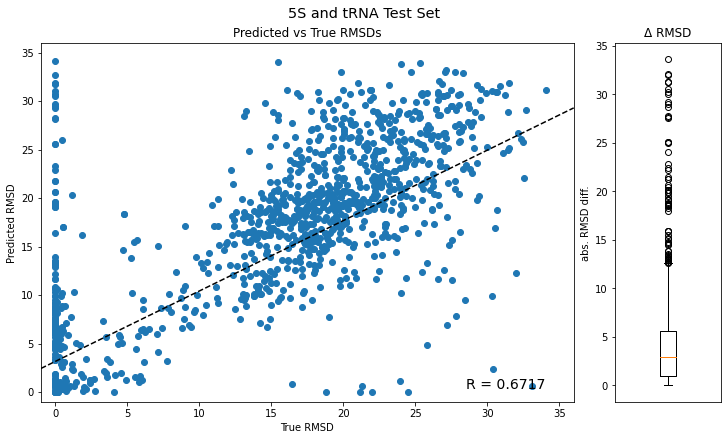

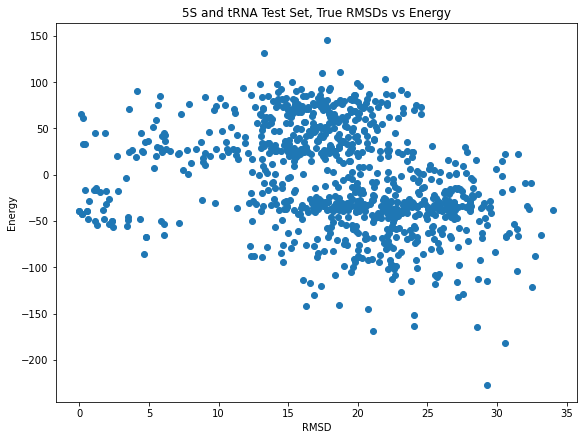

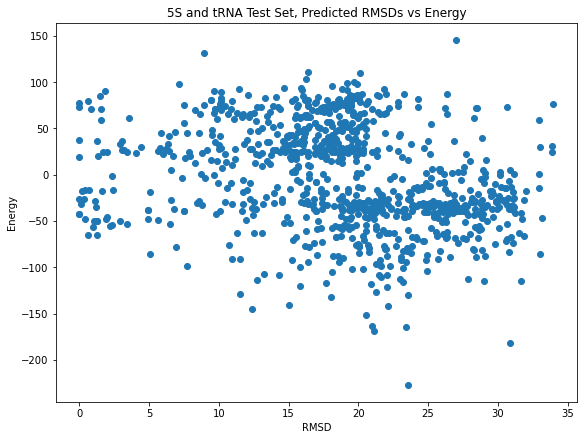

Training Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[15.8280]], device='cuda:0') tensor([[19.6850]], device='cuda:0') 3.3569822311401367
Mean Test loss: 	 0.4945
Std. Dev. of Test loss:  0.6136
Min loss: 		 0.0000
First Quantile: 	 0.0385
Median: 		 0.2187
Third Quantile: 	 0.7689
Max Loss: 		 3.3570
LinregressResult(slope=0.9639905997143363, intercept=0.35242818119854036, rvalue=0.993721391949644, pvalue=0.0, stderr=0.0039421893262750985, intercept_stderr=0.08087248481893507)


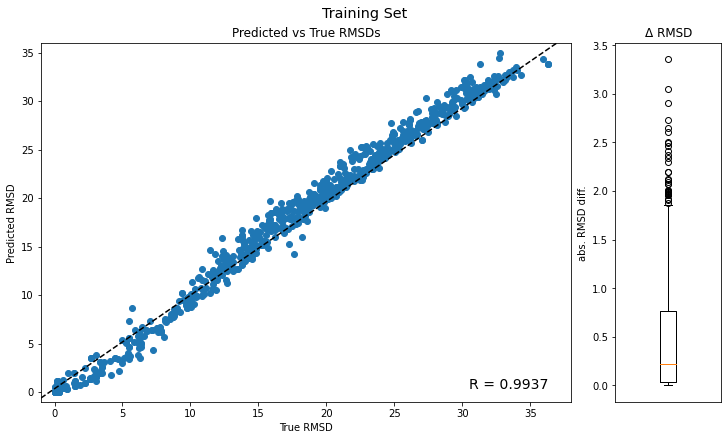

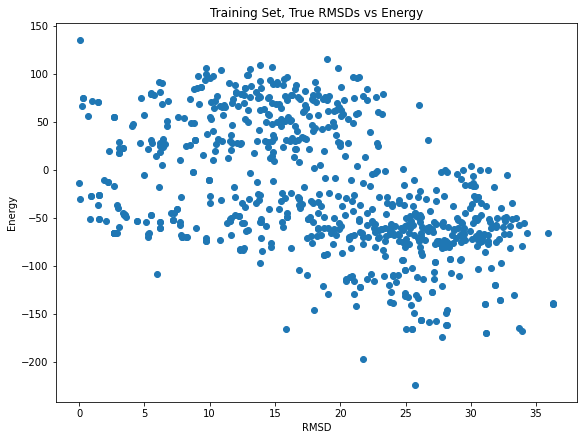

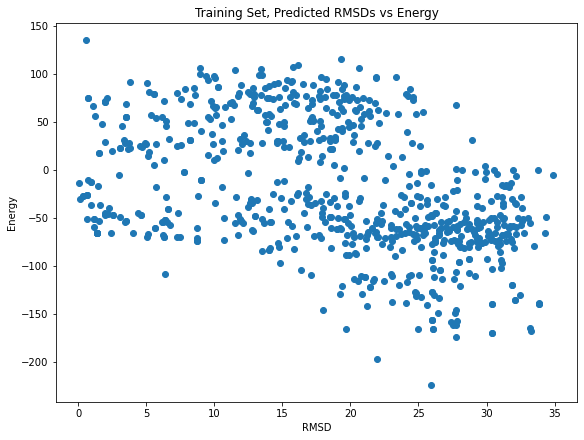

Validation Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[60.2560]], device='cuda:0') tensor([[6.8910]], device='cuda:0') 52.865013122558594
Mean Test loss: 	 14.0189
Std. Dev. of Test loss:  10.6016
Min loss: 		 0.0000
First Quantile: 	 5.2226
Median: 		 12.0736
Third Quantile: 	 20.9922
Max Loss: 		 52.8650
LinregressResult(slope=0.0006972798936776806, intercept=23.231018807157643, rvalue=0.0003307497157621369, pvalue=0.9947650928780696, stderr=0.10620856181543148, intercept_stderr=2.3137916911076877)


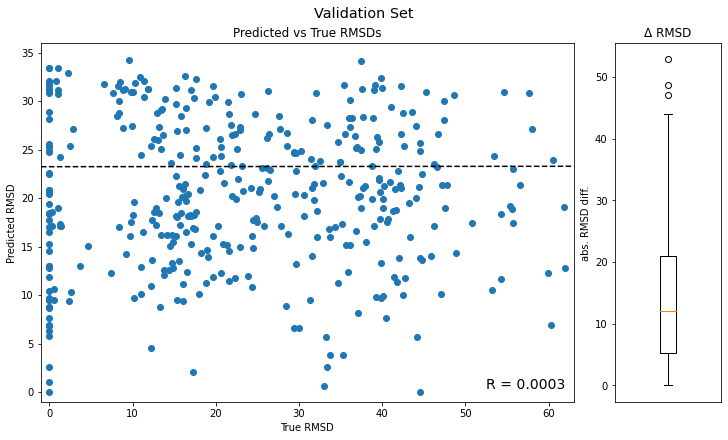

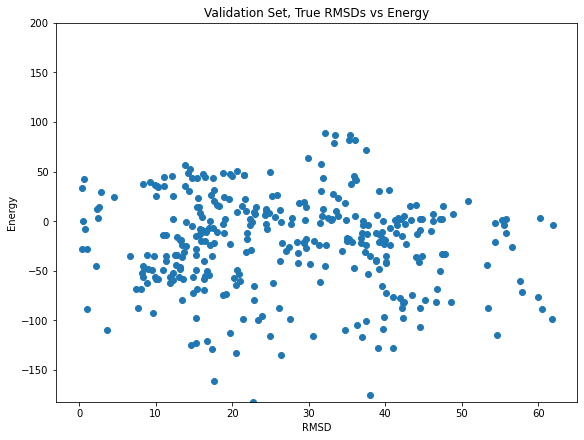

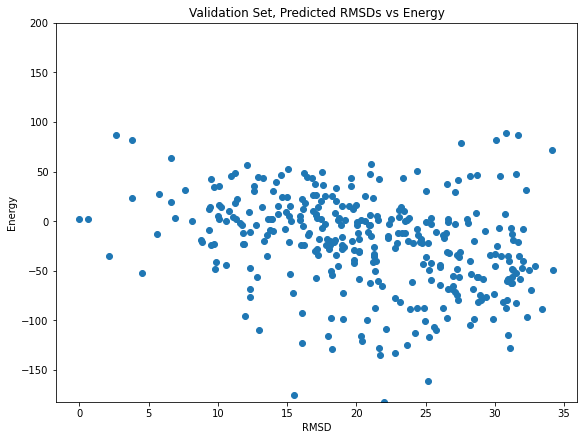

LinregressResult(slope=0.4388403363360085, intercept=12.322165970488694, rvalue=0.3263553515845181, pvalue=2.4343795140070713e-38, stderr=0.032939259427186965, intercept_stderr=0.6841517286815674)


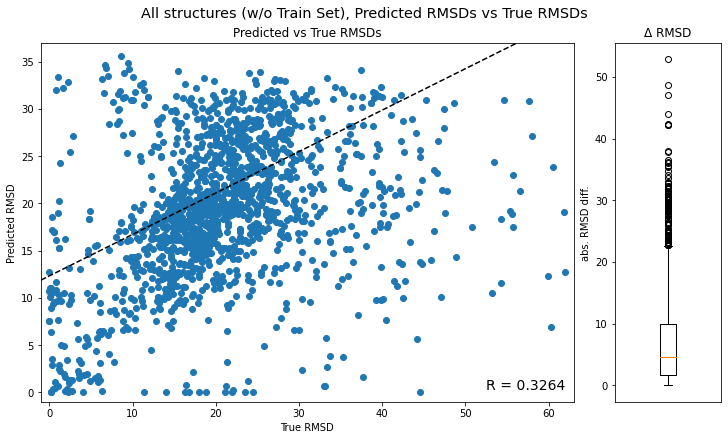

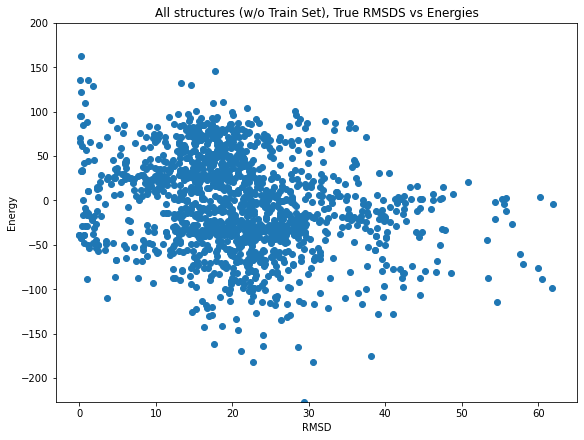

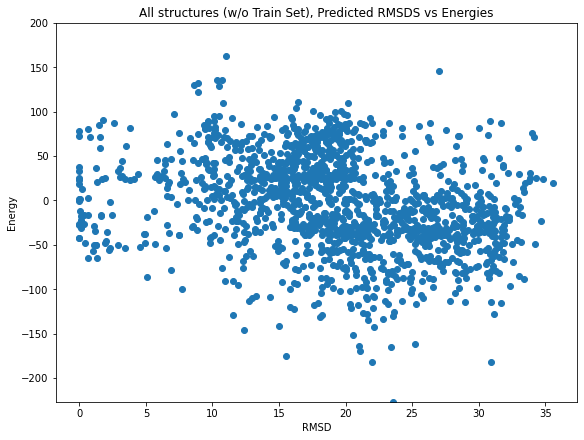

In [6]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = Diff_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_diff_model_data/model_epoch1800.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = diff_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9288156322141831, intercept=1.1752944135125638, rvalue=0.9106490835753838, pvalue=1.4477635551173196e-107, stderr=0.02541277463396532, intercept_stderr=0.5101522119192429)


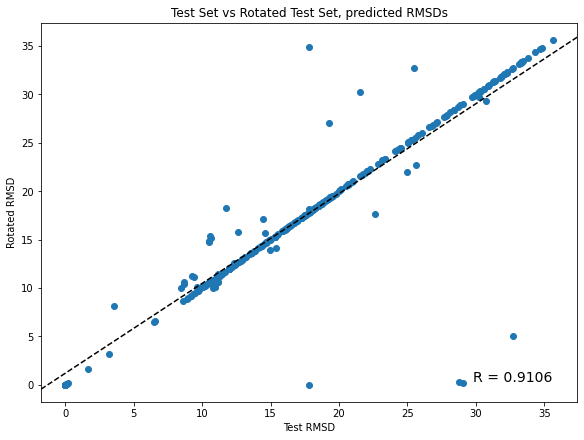

LinregressResult(slope=0.8831889797572275, intercept=1.0433895546732295, rvalue=0.877373871644044, pvalue=1.0755290001222426e-89, stderr=0.029125238508949373, intercept_stderr=0.35586287591659554)


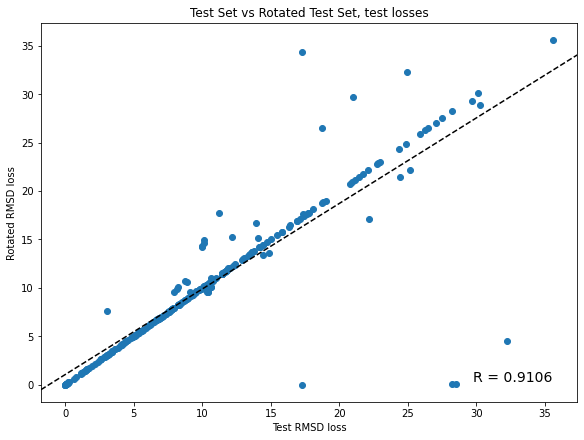

LinregressResult(slope=0.958125383389337, intercept=0.6854144407150073, rvalue=0.9534404651085855, pvalue=0.0, stderr=0.009217652375551652, intercept_stderr=0.17872077752173607)


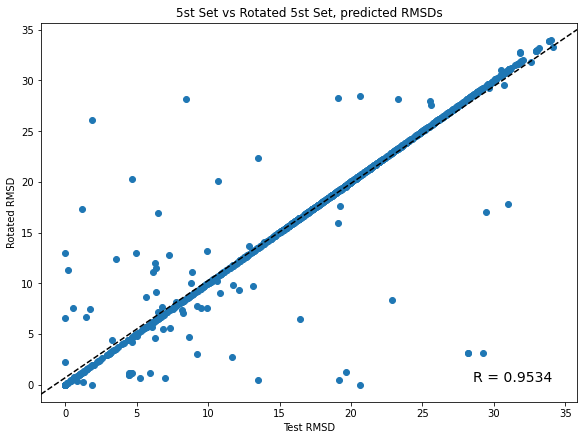

LinregressResult(slope=0.8752877638043994, intercept=0.4982224498986034, rvalue=0.8844667555477168, pvalue=0.0, stderr=0.014044433351279504, intercept_stderr=0.09620357195708697)


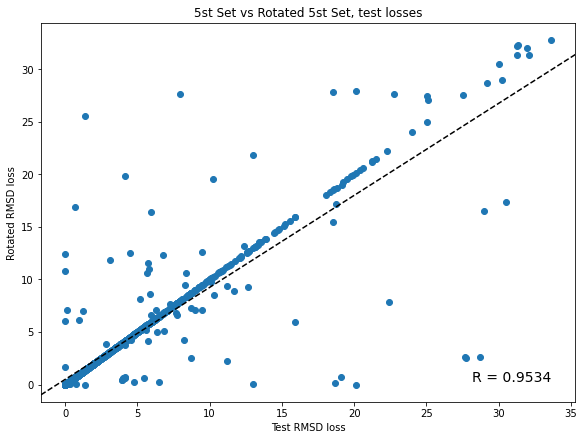

In [7]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")